## Yichun Shuai's data

In [1]:
%%javascript
IPython.OutputArea.auto_scroll_threshold = 9999;

<IPython.core.display.Javascript object>

In [2]:
import warnings
warnings.filterwarnings('ignore')
import os
import sys
import caiman as cm
import numpy as np
import scipy as sp
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set(font_scale=1.5)
sns.set_style("white")
%load_ext autoreload
%autoreload 2
fish_path = os.path.abspath(os.path.join('..'))
if fish_path not in sys.path:
    sys.path.append(fish_path)
import h5py

### Cell #1

In [3]:
fileName = 'Data/SimultaneousEphys_YS/simultaneousPatch_fly.mat'
with h5py.File(fileName, 'r') as f:
    voltr_c = f['voltron_contralateral']['dff'][()].flatten()
    voltr_time = f['voltron_contralateral']['time'][()].flatten()
    voltr_i = f['voltron_ipsilateral']['dff'][()].flatten()
    ephys = f['wholeCell']['voltage'][()].flatten()
    spk = f['wholeCell']['spikeTime'][()].flatten()
    ephys_time = f['wholeCell']['time'][()].flatten()

In [4]:
from scipy import signal

def removeTrend(y):
    y_ = y.astype(np.double)
    x_sg = signal.savgol_filter(y, 511, 3)
    return -(y_ - x_sg)

In [5]:
contr_f = removeTrend(voltr_c)
ipsi_f = removeTrend(voltr_i)

In [6]:
from trefide.solvers.lagrangian import lpdas, ipm
from trefide.solvers.constrained import cpdas
from trefide.temporal import TrendFilter
from scipy.sparse.linalg import lsqr, lsmr

def lambda_max_D2(y):
    y = y[:,np.newaxis]
    n = y.size
    e = np.mat(np.ones((1, n)))
    D = sp.sparse.spdiags(np.vstack((e, -2*e, e)), range(3), n-2, n)
    x, istop, itn, normr = lsmr(D.T, y)[:4]
    return np.linalg.norm(x, ord=np.inf)

In [7]:
# filt = TrendFilter(len(ipsi_f))
# ipsi_tf = filt.denoise(ipsi_f)
# contr_tf = filt.denoise(contr_f)

In [8]:
lam = lambda_max_D2(ipsi_f)
ipsi_tf, _, _ = lpdas(ipsi_f, lam/30)
lam = lambda_max_D2(contr_f)
contr_tf, _, _ = lpdas(contr_f, lam/30)
ipsi_tf = np.array(ipsi_tf)
contr_tf = np.array(contr_tf)

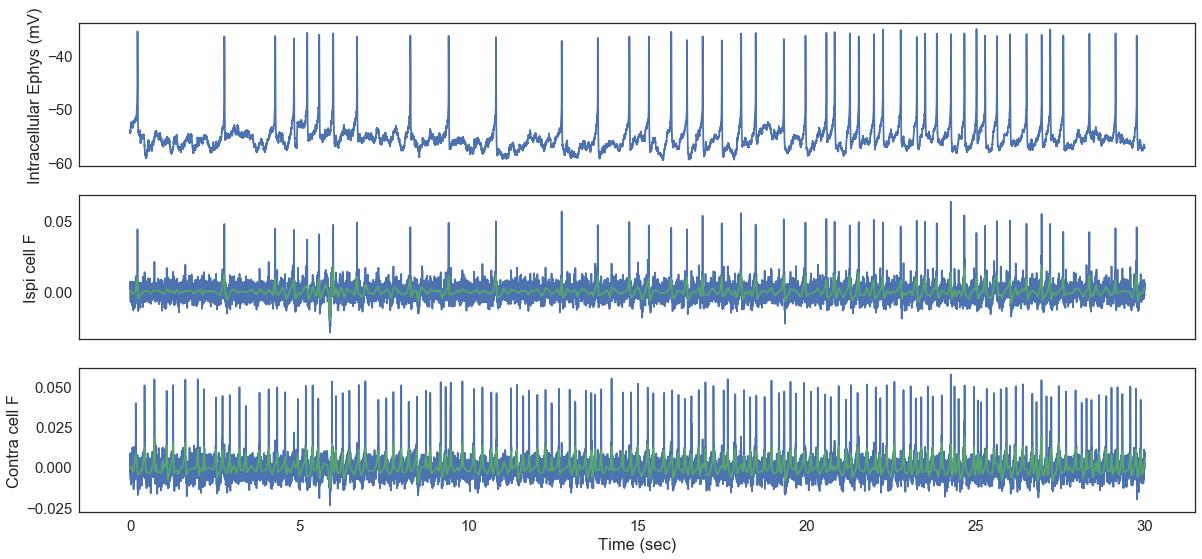

In [9]:
fig, ax = plt.subplots(3, 1, figsize = (20, 9), sharex=True)
ax[0].plot(ephys_time, ephys)
ax[0].set_ylabel('Intracellular Ephys (mV)')
ax[1].plot(voltr_time, ipsi_f)
ax[1].plot(voltr_time, ipsi_tf)
ax[1].set_ylabel('Ispi cell F')
ax[2].plot(voltr_time, contr_f)
ax[2].plot(voltr_time, contr_tf)
ax[2].set_ylabel('Contra cell F')
ax[2].set_xlabel('Time (sec)')
# ax[2].set_xlim([5, 10])

plt.show()

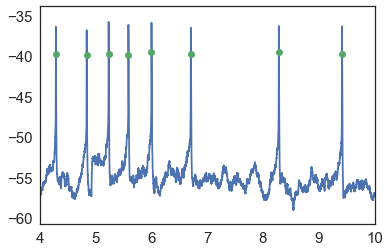

In [10]:
ephysTime = ephys>-40
ephysTime = ephysTime.astype('int')
ephysTimeDiff = ephysTime[1:] - ephysTime[:-1]
spkTime = np.where(ephysTimeDiff==1)
spkTime = np.array(spkTime).flatten() + 1
plt.plot(ephys_time, ephys)
plt.plot(ephys_time[spkTime], ephys[spkTime], 'o')
plt.xlim([4, 10])
plt.show()
spk_counts, _ = np.histogram(ephys_time[spkTime], bins=voltr_time)
np.savez('tmpData/YS_in_spk_voltr', spk_counts, ipsi_f[1:], ipsi_tf[1:])

### Get subthreshold activity

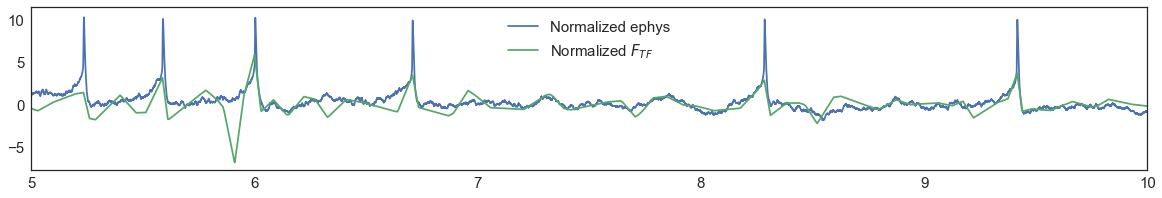

In [11]:
ephys_thres = -50.0
sub_ephys = ephys.copy()
sub_ephys[sub_ephys>ephys_thres] = ephys_thres
# sub_ephys = (sub_ephys - sub_ephys.mean())/sub_ephys.std()

ipsi_tf_change = abs(2*ipsi_tf[1:-1] - ipsi_tf[2:] - ipsi_tf[0:-2])*800
ipsi_tf_change = ipsi_tf_change>1e-10
ipsi_tf_change = np.insert(ipsi_tf_change, 0, True)
ipsi_tf_change = np.append(ipsi_tf_change, True)

voltr_fit = ipsi_tf[ipsi_tf_change]
voltr_fit = np.insert(voltr_fit, 0, voltr_fit[0])
voltr_fit = np.append(voltr_fit, voltr_fit[-1])
time_fit = voltr_time[ipsi_tf_change]
time_fit = np.insert(time_fit, 0, ephys_time[0])
time_fit = np.append(time_fit, ephys_time[-1])

from scipy import interpolate
int_voltr_tf = interpolate.interp1d(time_fit, voltr_fit, kind='linear', axis=0)
ipsi_tf_ = int_voltr_tf(ephys_time)
ipsi_tf_ = (ipsi_tf_ - ipsi_tf_.mean())/ipsi_tf_.std()

plt.figure(figsize=(20, 3))
plt.plot(ephys_time, (ephys - sub_ephys.mean())/sub_ephys.std(), label='Normalized ephys')
plt.plot(ephys_time, ipsi_tf_, label=r'Normalized $F_{TF}$')
# plt.plot(voltr_time, (ipsi_tf - ipsi_tf.mean())/ipsi_tf.std())
# plt.plot(time_fit, (voltr_fit - ipsi_tf.mean())/ipsi_tf.std())
plt.legend()
plt.xlim([5, 10])
plt.show()

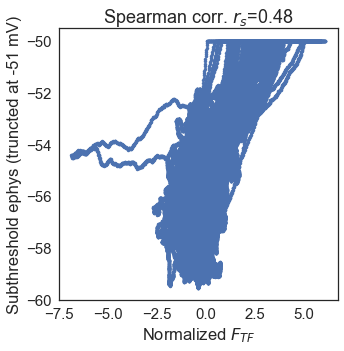

In [12]:
import scipy.stats as sstats
plt.figure(figsize=(5, 5))
plt.plot(ipsi_tf_, sub_ephys, '.')
rho, pval = sstats.spearmanr(ipsi_tf_,sub_ephys)
plt.title(r'Spearman corr. $r_s$=%.2f'%(rho))
plt.ylabel('Subthreshold ephys (truncted at -51 mV)')
plt.xlabel(r'Normalized $F_{TF}$')
plt.show()

In [13]:
ipsi_med = signal.medfilt(ipsi_f, 51)

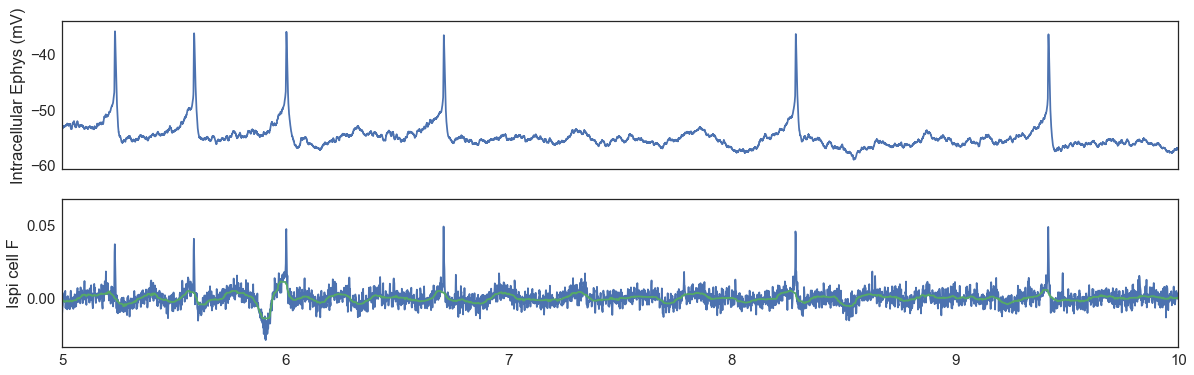

In [14]:
fig, ax = plt.subplots(2, 1, figsize = (20, 6), sharex=True)
ax[0].plot(ephys_time, ephys)
ax[0].set_ylabel('Intracellular Ephys (mV)')
ax[1].plot(voltr_time, ipsi_f)
ax[1].plot(voltr_time, ipsi_med)
ax[1].set_ylabel('Ispi cell F')
ax[1].set_xlim([5, 10])

plt.show()

In [15]:
voltr_fit = ipsi_med
voltr_fit = np.insert(voltr_fit, 0, voltr_fit[0])
voltr_fit = np.append(voltr_fit, voltr_fit[-1])
time_fit = voltr_time
time_fit = np.insert(time_fit, 0, ephys_time[0])
time_fit = np.append(time_fit, ephys_time[-1])

from scipy import interpolate
int_voltr_med = interpolate.interp1d(time_fit, voltr_fit, kind='cubic', axis=0)
ipsi_med_ = int_voltr_med(ephys_time)
ipsi_med_ = (ipsi_med_ - ipsi_med_.mean())/ipsi_med_.std()

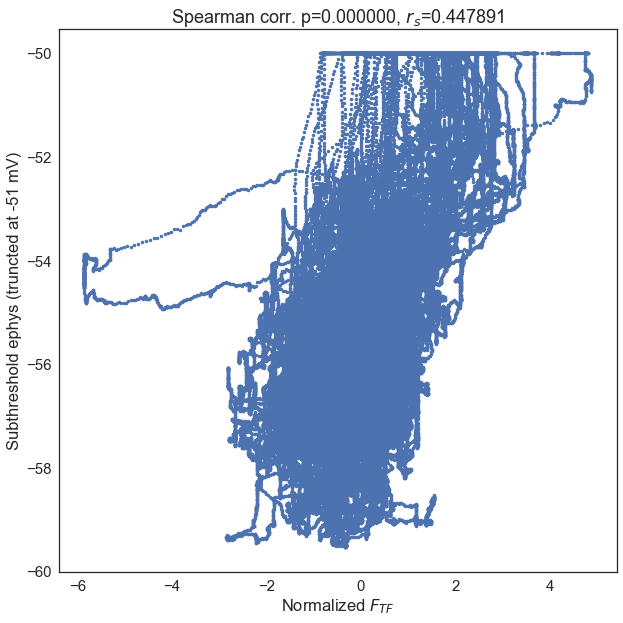

In [16]:
plt.figure(figsize=(10, 10))
plt.plot(ipsi_med_, sub_ephys, '.')
rho, pval = sstats.spearmanr(ipsi_med_,sub_ephys)
plt.title(r'Spearman corr. p=%f, $r_s$=%f'%(pval, rho))
plt.ylabel('Subthreshold ephys (truncted at -51 mV)')
plt.xlabel(r'Normalized $F_{TF}$')
plt.show()

In [17]:
def compare_to_medfilter(filter_wid):
    ipsi_med = signal.medfilt(ipsi_f, filter_wid)
    voltr_fit = ipsi_med
    voltr_fit = np.insert(voltr_fit, 0, voltr_fit[0])
    voltr_fit = np.append(voltr_fit, voltr_fit[-1])
    time_fit = voltr_time
    time_fit = np.insert(time_fit, 0, ephys_time[0])
    time_fit = np.append(time_fit, ephys_time[-1])

    int_voltr_med = interpolate.interp1d(time_fit, voltr_fit, kind='cubic', axis=0)
    ipsi_med_ = int_voltr_med(ephys_time)
    rho, pval = sstats.spearmanr(ipsi_med_,sub_ephys)
    return rho

In [18]:
filter_wid = [11, 21, 51, 71, 81, 91, 101, 151, 201]
rhoList = []
for wid_ in filter_wid:
    rhoList.append(compare_to_medfilter(wid_))

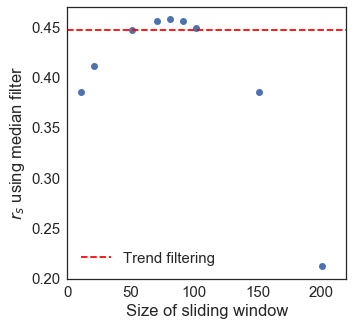

In [19]:
plt.figure(figsize=(5, 5))
plt.plot(filter_wid, rhoList, 'o')
plt.plot([0, 220], [rho, rho], '--r', label='Trend filtering')
plt.ylabel(r'$r_s$ using median filter')
plt.xlabel('Size of sliding window')
plt.xlim([0, 220])
plt.legend()
plt.show()

In [20]:
def spk_peaks(y, thres):
    peak = np.logical_and(y[1:-1]>y[0:-2], y[1:-1]>y[2:])
    peak = np.logical_and(y[1:-1]>thres, peak)
    locs=np.array(np.where(peak))+1
    return locs.flatten()

In [21]:
ephys = ephys - np.percentile(ephys, 50)
thres = ephys.std() * 6
spkTime = spk_peaks(ephys, thres)